<a href="https://colab.research.google.com/github/Ashu-00/AutoEncodersAndGenerators/blob/main/AutoEncoders(Sparse).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [ ]:
dataset=torchvision.datasets.MNIST('data',train=True,download=True,transform=torchvision.transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 912985.69it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 135045.07it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1069875.51it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4214718.75it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
generator1 = torch.Generator().manual_seed(42)
trainset,testset=torch.utils.data.random_split(dataset,[0.9,0.1],generator=generator1)

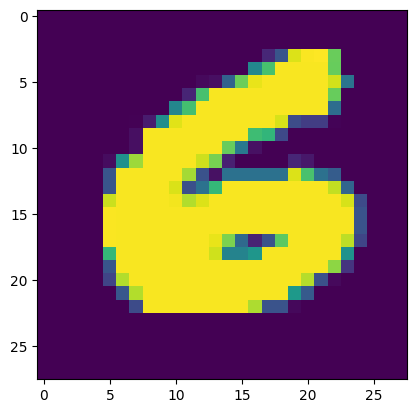

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(trainset[0][0].squeeze(0))

In [ ]:
class SparseAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.enc1 = nn.Conv2d(1,8,3,stride=1)
    self.enc2 = nn.Conv2d(8,16,5,stride=1)
    self.enc3 = nn.Conv2d(16,32,5,stride=2)
    self.bottle = nn.MaxPool2d(2, 2)

    self.dec1 = nn.ConvTranspose2d(32,16,3, stride=2)
    self.dec2 = nn.ConvTranspose2d(16,8,5, stride=2)
    self.dec3 = nn.ConvTranspose2d(8,1,8, stride=1)

  def encoder(self,x):
    x=F.relu(self.enc1(x))
    x=F.relu(self.enc2(x))
    x=F.relu(self.enc3(x))
    x=self.bottle(x)
    return x

  def decoder(self,x):
    x=F.relu(self.dec1(x))
    x=F.relu(self.dec2(x))
    x=torch.sigmoid(self.dec3(x))
    return x


  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

  def forwardwithlayers(self,x):
    layers=[]
    x1=F.relu(self.enc1(x))
    layers.append(x1)
    x2=F.relu(self.enc2(x1))
    layers.append(x2)
    x3=F.relu(self.enc3(x2))
    layers.append(x3)
    x4=self.bottle(x3)
    layers.append(x4)
    x5=F.relu(self.dec1(x4))
    layers.append(x5)
    x6=F.relu(self.dec2(x5))
    layers.append(x6)
    xans=torch.sigmoid(self.dec3(x6))
    return xans,layers


In [ ]:
def l1_reg(layers, lambda_=4e-5):
  loss = 0
  for i in layers:
    loss += torch.mean(torch.abs(i))

  return lambda_*loss

In [ ]:
def train(model,train_loader,epochs=3,lr=9e-3,device="cpu"):
  model.train()
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr)
  lossfunc=nn.BCELoss()
  lossavg=0

  for epoch in range(epochs):
    for (bid,(inp,lab)) in enumerate(train_loader):
      inp=inp.to(device)
      optimizer.zero_grad()
      #lab=lab.to(device)
      out,layers=model.forwardwithlayers(inp)
      loss=lossfunc(out,inp)
      loss+=l1_reg(layers)
      loss.backward()
      optimizer.step()
      lossavg+=loss.item()
      if bid%10==0:
        print(f"epoch:{epoch} batch={bid} loss:{loss.item()}")

    print(f"epoch:{epoch} loss:{lossavg/len(train_loader)}")


In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

In [ ]:
model=SparseAE()
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
train(model,trainloader,epochs=1,device=device)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch:0 batch=0 loss:0.6857127547264099
epoch:0 batch=10 loss:0.5559569001197815
epoch:0 batch=20 loss:0.5261126160621643
epoch:0 batch=30 loss:0.5096046924591064
epoch:0 batch=40 loss:0.35141128301620483
epoch:0 batch=50 loss:0.284233957529068
epoch:0 batch=60 loss:0.23458637297153473
epoch:0 batch=70 loss:0.21032823622226715
epoch:0 batch=80 loss:0.18221355974674225
epoch:0 batch=90 loss:0.16149508953094482
epoch:0 batch=100 loss:0.14522506296634674
epoch:0 batch=110 loss:0.14205923676490784
epoch:0 batch=120 loss:0.13219597935676575
epoch:0 batch=130 loss:0.12635722756385803
epoch:0 batch=140 loss:0.12199205905199051
epoch:0 batch=150 loss:0.12338988482952118
epoch:0 batch=160 loss:0.12222610414028168
epoch:0 batch=170 loss:0.1205168142914772
epoch:0 batch=180 loss:0.12688423693180084
epoch:0 batch=190 loss:0.11361302435398102
epoch:0 batch=200 loss:0.11416411399841309
epoch:0 batch=210 loss:0.11408314853906631
epoch:0 batch=220 loss:0.10900922119617462
epoch:0 batch=230 loss:0.1057

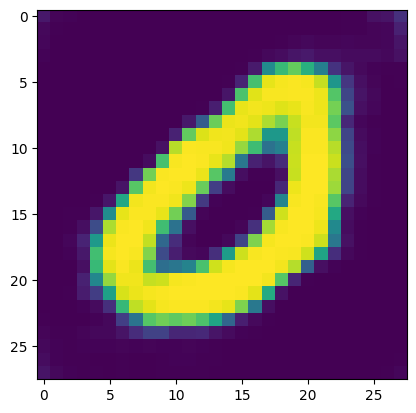

In [ ]:
#test1

img=testset[2][0].to(device).unsqueeze(0)
out=model(img)
plt.imshow(out.detach().cpu().squeeze(0)[0,:,:])


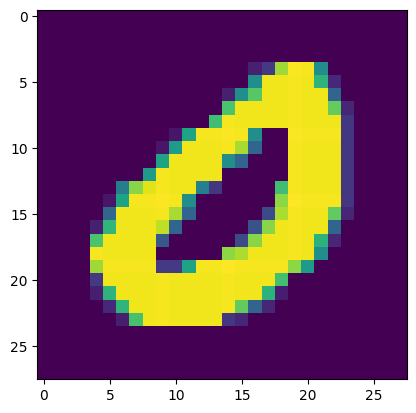

In [ ]:
plt.imshow(img.detach().cpu().squeeze(0)[0,:,:])

In [ ]:
def test(model,test_loader,device="cpu"):
  model.eval()
  model.to(device)
  lossfunc=nn.BCELoss()
  lossavg=0

  for (bid,(inp,lab)) in enumerate(test_loader):
      inp=inp.to(device)

      #lab=lab.to(device)
      out,layers=model.forwardwithlayers(inp)
      loss=lossfunc(out,inp)
      loss+=l1_reg(layers)
      lossavg+=loss.item()

      print(f"batch={bid} loss:{loss.item()}")

  print(f"loss Average:{lossavg/len(test_loader)}")

In [ ]:
test(model,testloader,device=device)

batch=0 loss:0.09922058135271072
batch=1 loss:0.10387694835662842
batch=2 loss:0.10338492691516876
batch=3 loss:0.09935486316680908
batch=4 loss:0.09740652143955231
batch=5 loss:0.09740173816680908
batch=6 loss:0.10434915125370026
batch=7 loss:0.09805595129728317
batch=8 loss:0.10283710062503815
batch=9 loss:0.10525161027908325
batch=10 loss:0.0976245254278183
batch=11 loss:0.10081275552511215
batch=12 loss:0.10194876044988632
batch=13 loss:0.10157253593206406
batch=14 loss:0.1041533499956131
batch=15 loss:0.10416299104690552
batch=16 loss:0.10158218443393707
batch=17 loss:0.09612970799207687
batch=18 loss:0.10190706700086594
batch=19 loss:0.10438215732574463
batch=20 loss:0.09969862550497055
batch=21 loss:0.09875905513763428
batch=22 loss:0.09759512543678284
batch=23 loss:0.09961241483688354
batch=24 loss:0.1027197390794754
batch=25 loss:0.09425829350948334
batch=26 loss:0.10058286041021347
batch=27 loss:0.09960906207561493
batch=28 loss:0.09633439779281616
batch=29 loss:0.09979629516

In [ ]:
def kl_reg(layers,rho=0.05,beta=0.005):
  loss=0
  for i in layers:
    loss+=F.kl_div(torch.mean(i,dim=0),rho*torch.ones_like(i[0]))
  return beta*torch.abs(loss)

In [ ]:
def trainoverKLreg(model,train_loader,epochs=3,lr=9e-3,device="cpu"):
  model.train()
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr)
  lossfunc=nn.BCELoss()
  lossavg=0

  for epoch in range(epochs):
    for (bid,(inp,lab)) in enumerate(train_loader):
      inp=inp.to(device)
      optimizer.zero_grad()
      #lab=lab.to(device)
      out,layers=model.forwardwithlayers(inp)
      loss=lossfunc(out,inp)
      loss+=kl_reg(layers)
      loss.backward()
      optimizer.step()
      lossavg+=loss.item()
      if bid%10==0:
        print(f"epoch:{epoch} batch={bid} loss:{loss.item()}")

    print(f"epoch:{epoch} loss:{lossavg/len(train_loader)}")


In [ ]:
modelforklreg=SparseAE()
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
trainoverKLreg(modelforklreg,trainloader,epochs=1,device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


epoch:0 batch=0 loss:0.6771348714828491
epoch:0 batch=10 loss:0.5182934999465942
epoch:0 batch=20 loss:0.2997727692127228
epoch:0 batch=30 loss:0.2688724994659424
epoch:0 batch=40 loss:0.25636494159698486
epoch:0 batch=50 loss:0.2203778475522995
epoch:0 batch=60 loss:0.21473319828510284
epoch:0 batch=70 loss:0.19621767103672028
epoch:0 batch=80 loss:0.1920105665922165
epoch:0 batch=90 loss:0.16789521276950836
epoch:0 batch=100 loss:0.1584567278623581
epoch:0 batch=110 loss:0.149592325091362
epoch:0 batch=120 loss:0.14115245640277863
epoch:0 batch=130 loss:0.13665391504764557
epoch:0 batch=140 loss:0.1229889914393425
epoch:0 batch=150 loss:0.11898007988929749
epoch:0 batch=160 loss:0.1116340383887291
epoch:0 batch=170 loss:0.11191126704216003
epoch:0 batch=180 loss:0.11002583801746368
epoch:0 batch=190 loss:0.11361617594957352
epoch:0 batch=200 loss:0.10946241021156311
epoch:0 batch=210 loss:0.10784905403852463
epoch:0 batch=220 loss:0.10725333541631699
epoch:0 batch=230 loss:0.10609412

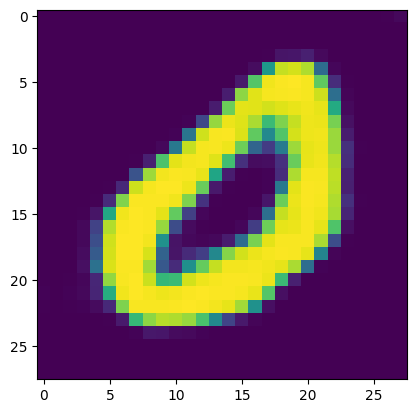

In [ ]:
#test1

img=testset[2][0].to(device).unsqueeze(0)
out=modelforklreg(img)
plt.imshow(out.detach().cpu().squeeze(0)[0,:,:])


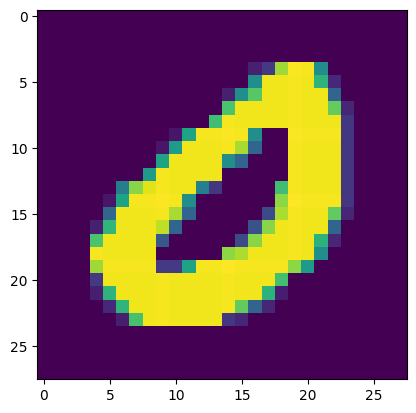

In [ ]:
plt.imshow(img.detach().cpu().squeeze(0)[0,:,:])

In [ ]:
def testoverkl(model,test_loader,device="cpu"):
  model.eval()
  model.to(device)
  lossfunc=nn.BCELoss()
  lossavg=0

  for (bid,(inp,lab)) in enumerate(test_loader):
      inp=inp.to(device)

      #lab=lab.to(device)
      out,layers=model.forwardwithlayers(inp)
      loss=lossfunc(out,inp)
      loss+=kl_reg(layers)
      lossavg+=loss.item()

      print(f"batch={bid} loss:{loss.item()}")

  print(f"loss Average:{lossavg/len(test_loader)}")

In [ ]:
test(modelforklreg,testloader,device=device)

batch=0 loss:0.08902769535779953
batch=1 loss:0.09145691990852356
batch=2 loss:0.09188204258680344
batch=3 loss:0.08804026991128922
batch=4 loss:0.08771392703056335
batch=5 loss:0.085618756711483
batch=6 loss:0.09322867542505264
batch=7 loss:0.0863443985581398
batch=8 loss:0.09029310196638107
batch=9 loss:0.09242968261241913
batch=10 loss:0.08586923032999039
batch=11 loss:0.08924682438373566
batch=12 loss:0.09102417528629303
batch=13 loss:0.09061747044324875
batch=14 loss:0.0924718827009201
batch=15 loss:0.09215375781059265
batch=16 loss:0.08956912159919739
batch=17 loss:0.08526673167943954
batch=18 loss:0.0897204577922821
batch=19 loss:0.09442595392465591
batch=20 loss:0.08913454413414001
batch=21 loss:0.08896061033010483
batch=22 loss:0.08629719167947769
batch=23 loss:0.08812785893678665
batch=24 loss:0.09004229307174683
batch=25 loss:0.08397933840751648
batch=26 loss:0.08770640939474106
batch=27 loss:0.08894707262516022
batch=28 loss:0.08642619848251343
batch=29 loss:0.0894125550985